# Week 3: Classifying ASL Gestures using LSTMs
<a href="https://colab.research.google.com/github/MichiganDataScienceTeam/W26-Sign-Language-Translator/blob/main/Week%203/week3_wlasl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install mediapipe

# Mount Google Drive (will prompt for authorization)
from google.colab import drive
import zipfile

drive.mount('/content/drive')
zip_url = '/content/drive/MyDrive/wlasl_small.zip'

with zipfile.ZipFile(zip_url, 'r') as zip_ref:
    zip_ref.extractall("/content")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import torch
from dataloader import get_dataloader
from training import train_model, visualize_results, plot_confusion_matrix

if torch.cuda.is_available():
    print("Using device: gpu")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using device: mps")
    device = torch.device("mps")
else:
    print("Using device: cpu")
    device = torch.device("cpu")

# create dataloaders (may take a while to process landmarks)
dataset_name = "asl_glosses"
train_loader = get_dataloader(
    dataset_name=dataset_name,
    partition = "train",
    as_landmarks = True,
    batch_size=1)
val_loader = get_dataloader(
    dataset_name=dataset_name,
    partition = "val",
    as_landmarks = True,
    batch_size=1)


Using GPU
Using device: gpu
Download complete!
initializing train dataloader...
finished initializing train dataloader!
initializing val dataloader...
finished initializing val dataloader!


In [6]:
class Video_LSTM(torch.nn.Module):
    def __init__(self, input_size=42, hidden_size=128, num_layers=2, dropout: float = 0, num_classes=5):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = torch.nn.LSTM(
            input_size=input_size,
            hidden_size = hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )

        self.fc1 = torch.nn.Linear(hidden_size, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)

    def forward(self, x, h0=None, c0=None):
        # Expect x: (B, T, input_size) because batch_first=True
        batch_size = x.size(0)
        if h0 is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        out, _ = self.lstm(x, (h0, c0))
        logits = self.fc1(out[:, -1, :])  # last time step
        logits = self.fc2(logits)
        return logits

# TODO: modify hyperparameters to improve performance
# TIP: you may want to decrease the learning rate, and
#      increase the number of epochs

epochs = 10
lr = 5e-3
n_layers = 2
hidden_size = 128
dropout = 0

model_name = "current_model"
model_prefix = f"{model_name}"
vis_prefix = model_prefix


Epoch 9: 100%|██████████| 22/22 [00:00<00:00, 298.89it/s, loss=0.682, val_acc=0.429, val_loss=0.696]


saved best model to saved_models/current_model_fc_model.pth: 0.428571% accuracy
losses saved to saved_plots/current_model_losses.png
accuracies saved to saved_plots/current_model_accuracy.png
confusion matrices saved to saved_plots/current_model_confusion_matrix.png


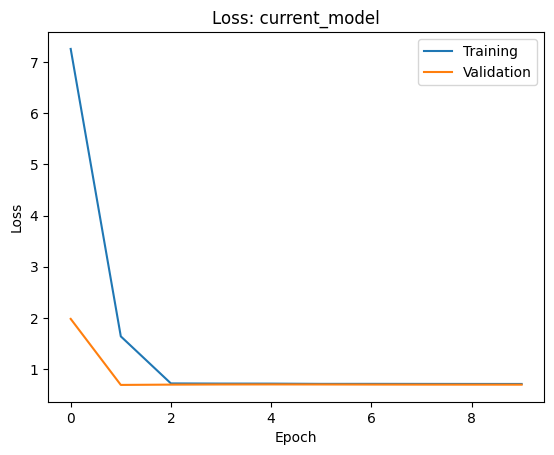

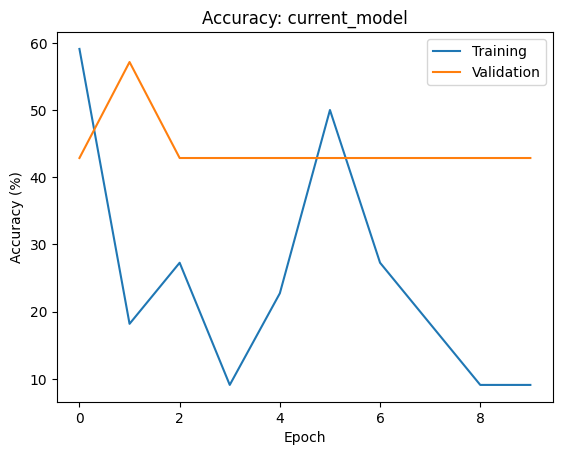

In [7]:
model = Video_LSTM(hidden_size = hidden_size, dropout=dropout, num_layers=n_layers, num_classes=2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

results = train_model(model, criterion, optimizer, train_loader, val_loader, epochs, save_prefix=model_prefix)

visualize_results(results, save_prefix=vis_prefix)

class_names = ["go", "computer"]
plot_confusion_matrix(results, class_names=class_names, save_prefix=vis_prefix)